## LukG PyInteraph Analysis

In [2]:
from pathlib import Path
from sys import path
path.append("../final_pyfferaph")

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from pyfferaph import pyfferaph as pf
from pyfferaph import filter_pyff as pyff 
import MDAnalysis as mda
import pandas as pd
import multiprocessing

In [7]:
# NOTES:
# The package seems to have problems with MDAnalysis 2.3.0 
# we used MDAnalysis version 2.4.2

All the input files and selections are specified using dictionaries 

**data_dict** contains the trajectory and topology files. 

**analysis_dict** contains the selection of the N residues for which the interaction networks (N x N matrices) will be computed, the stride used to read the trajectory file and the starting and ending frame to be analysed.

**salt_dict** contains the selection for the salt bridge interactions, the default distance is set to 4.5 A and the output name for the interaction file.

**hc_dict** contains the selection for the hydrophbic interactions, the default distance is set to 5 A and the output name for the interaction file.

**hb_dict** contains the selection for the hydrogen bonds, the default distance is set to 3.5 A, the Donor-H-Acceptor angle to 120° and the output name for the interaction file. Since this function can run on more than one core the number of cores is specified here, 0 means that pyfferaph will make use of all the available cores.

In [5]:
# simulation data directory
simdir = Path("../data/")
figs = Path("../figures/pyfferaph/")

pdb = simdir / "LukG_AF2.pdb"
trj = simdir / "trajectory_noPBC_alignedCA.xtc"
top = simdir / "step7_final.tpr"

In [6]:
# Input
data_dict = dict(pdb=str(pdb),
                 traj=str(trj),
                 top=str(top))

In [7]:
# Analysis dict:

# Common data: the argument `system` is required to create the proper
# matrix. Use "protein or resname DGPS" if you want include DGPS lipids
analysis_dict = dict(system="protein",
                     start = 0,
                     stop = None, 
                     stride = 15    # initially 1, set as block analysis stride.
                    )

# Salt bridge selection. To include lipids, modify `sel_basic` and `sel_acidic` accordingly.
sb_dict = dict(sb_file="../final_pyfferaph/example_matrices/my_sb.dat",
               sel_basic="(resname LYS and name CE NZ HZ*) or (resname ARG and name CD NE CZ NH1 NH2 HH11 HH12 HH21 HH22)",
               sel_acidic="(resname ASP and name CG OD1 OD2) or (resname GLU and name CD OE1 OE2)",
               sb_dist=4.5,
               # Define if there are charged cter, nter and protonated his
               cter_sel="(resid 148 and name C OT1 OT2)",
               nter_sel="",
               histidine_sel=""
              )

# The hydrophobic contacts
hc_dict = dict(hc_file="../final_pyfferaph/example_matrices/my_hc.dat",
               hydrophobic_sel="resname ALA ILE VAL LEU PHE MET TRP PRO", 
               backbone_sel="name N H HN CA HA C O OT1 OT2 HT2",
               hc_cutoff=5.
)

# Hydrogen bond selections. To include other molecule, modify acceptor and donor selections accordingly
# 
#NB: ncores defines the number of cores to run the hb analysis in parallel, ncores=0 means all the available cores.
hb_dict = dict(hb_file="../final_pyfferaph/example_matrices/my_hb.dat",
               tmp_csv="../final_pyfferaph/example_matrices/tmp_file_hbonds",
               acceptors="protein and name OH OG OD1 OD2 OG1 O ND1 NE2 OE2 OW SG OE1 OH2 SD",
               donors="protein and name OH OG NE2 OG1 NE N ND1 NZ NH1 NH2 OW ND2 SG OH2 NE1",
               d_a_dist=3.5,
               angle=120,
               update_sel=False,
               ncores=5
)



# Salt bridges 

Computing the salt bridge interaction network and plotting the resulting matrix, 100 means that that specific interaction is observed in every one of the analysed frames

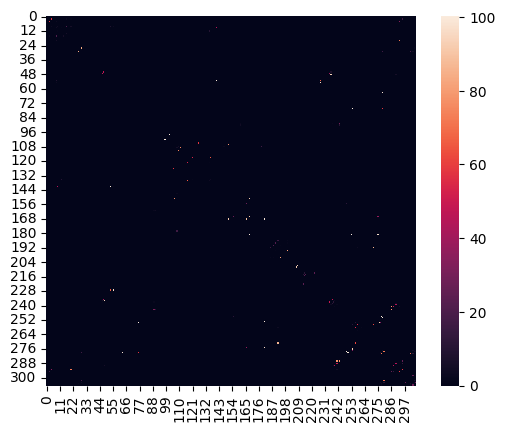

In [21]:
sb = pf.SaltBridges(input_dict=data_dict, 
                   analysis_dict=analysis_dict, 
                   sb_dict=sb_dict)

sb_network = sb.run()

sns.heatmap(sb_network, square=True)
plt.savefig(figs / "salt_bridge.png", dpi=400)

Plotting the size of the biggest salt bridge cluster as a function of increasing p min. The stride can be changed, default is set to 0.1.

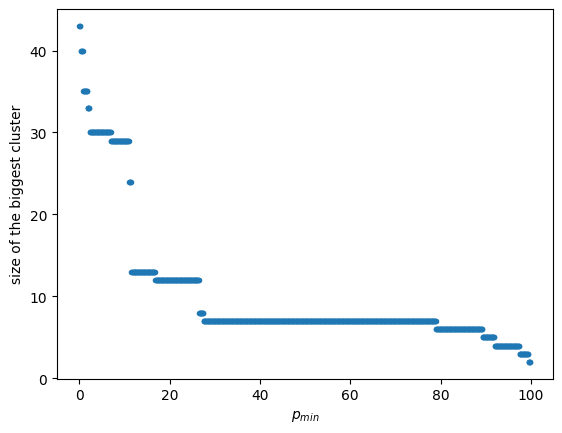

In [22]:
sb_matrix = np.loadtxt("../final_pyfferaph/example_matrices/my_sb.dat")
pyff.cluster_plotter(sb_matrix, 'sb_cluster.pdf', stride=0.1)

# Hydrophobic contacts

Computing the hydrophobic interaction network and plotting the resulting matrix, 100 means that that specific interaction is observed in every one of the analysed frames

/home/andrea/.local/lib/python3.10/site-packages/MDAnalysis/core/groups.py:440: DeprecationWarning: The 'pbc' kwarg has been deprecated and will be removed in version 3.0., please use 'wrap' instead
  warnings.warn("The 'pbc' kwarg has been deprecated and will be "


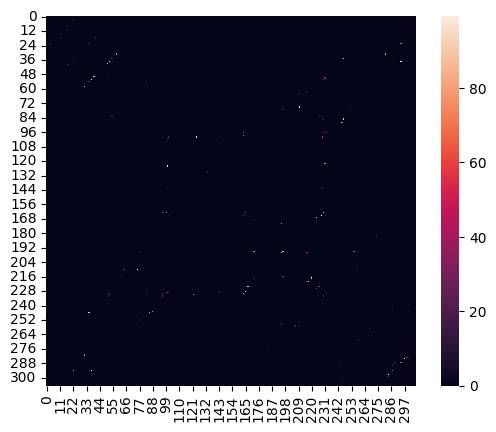

In [11]:
hc = pf.HydrophobicInteractions(input_dict=data_dict, 
                   analysis_dict=analysis_dict, 
                   hc_dict=hc_dict)

hc_network = hc.run()

sns.heatmap(hc_network, square=True)
plt.savefig(figs / "hydrophobic_contacts.png", dpi=400)

Plotting the size of the biggest hydrophobic contacts cluster as a function of increasing p min. The stride can be changed, default is set to 0.1.

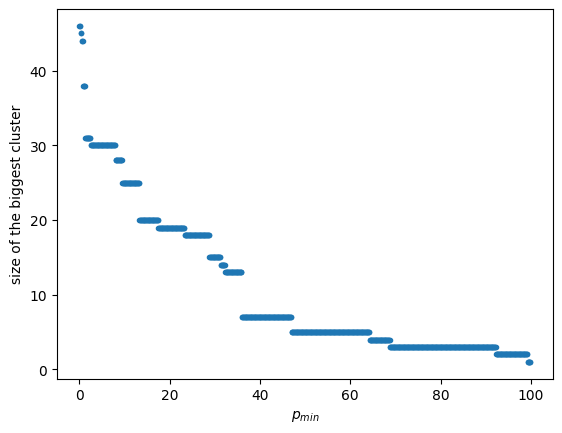

In [12]:
hc_matrix = np.loadtxt("../final_pyfferaph/example_matrices/my_hc.dat")
pyff.cluster_plotter(hc_matrix, 'hc_cluster.pdf')

# Hydrogen bonds


Initialsing the hydrogen bonds function 

In [13]:
# set in_memory to False because smoll RAM pc :(
u = mda.Universe(data_dict['top'], data_dict['traj'], in_memory=False)

# Need to know the number of entry to initialise the matrix
sel = u.select_atoms(analysis_dict['system'])
residxs = np.unique(sel.resindices)
nres = len(residxs)

# Need to know the number of frames to run in parallel
if analysis_dict['stop'] == None:
    nframes = (u.trajectory.n_frames - analysis_dict['start']) // analysis_dict['stride']
else:
    nframes = (analysis_dict['stop'] - analysis_dict['start']) // analysis_dict['stride']


Running HB analysis. This function returns as many csv files (containing the results of the hb analysis) as the number of cores used for the calculation. If only one core is given all the analysis will be run on a single core and only one csv file will be generated, if run on n cores n csv files will be generated.

In [ ]:
pf.HBondInteraction(data_dict['top'], data_dict['traj'], 
                 donor_sel=hb_dict['donors'], 
                 acceptor_sel=hb_dict['acceptors'], 
                 nframe=nframes, output_csv=hb_dict['tmp_csv'], ncores=hb_dict['ncores'])

merging all the csv files generated in the previous step

In [15]:
merged_df = pf.MergingHBDataframe(hb_dict['tmp_csv'], nframe=nframes, ncores=hb_dict['ncores'])

Using 5


generating and plotting the final HB matrix containing the results of HB analysis

In [16]:
# we added 1 to nres because the matrix of np.zeroes was too small and was raising a KeyError
pf.HBMatrix(u=u, nres=nres+1, nframes=nframes, hb_df=merged_df, 
         stride=analysis_dict['stride'], hb_file=hb_dict['hb_file'])

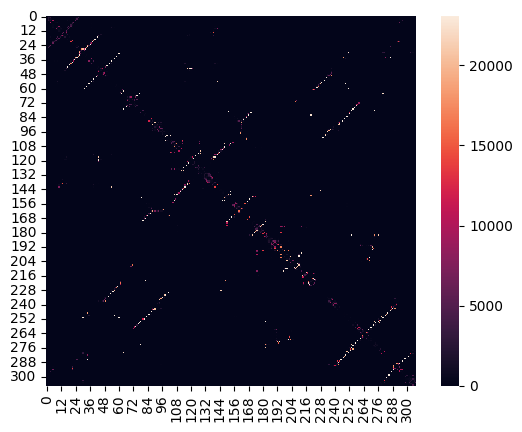

In [17]:
hb_matrix = np.loadtxt(hb_dict['hb_file'])
sns.heatmap(hb_matrix, square=True)
plt.savefig(figs / "hydrogen_bonds.png", dpi=400)

Plotting the size of the biggest hb cluster as a function of increasing p min. The stride can be changed, default is set to 0.1.

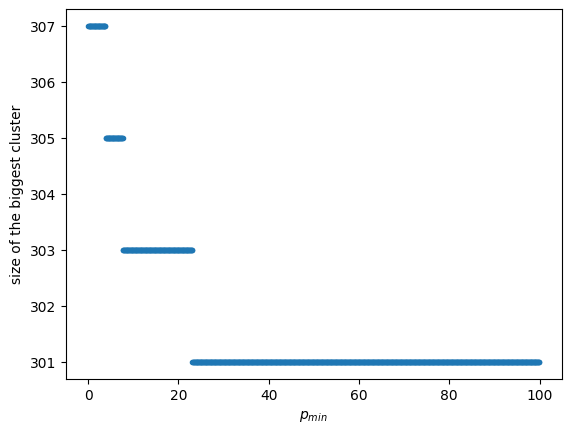

In [18]:
pyff.cluster_plotter(hb_matrix, 'hb_cluster.pdf')

# PSN

Generating the final Interaction Network merging together the sb, hc and hb matrix generated in the previous steps. The threshold for filtering is the same used by the authors of Pyinteraph for the example analysis

In [23]:
print("hc matrix: ", hc_matrix.shape) # 307, 307
print("sb matrix: ", sb_matrix.shape) # 307, 307
print("hb matrix: ", hb_matrix.shape) # 308, 308 # this is because of our change before!
# So we can:
#  - restrict hb_matrix manually
#  - change the code in another way for the previous analysis

hc matrix:  (307, 307)
sb matrix:  (307, 307)
hb matrix:  (308, 308)


In [24]:
# to manually restrict hb_matrix, let's check if there is a border without information
df = pd.DataFrame(hb_matrix)

# every column on the is equal to zero on the first element
# this == first row all zeroes
print(np.all(df.iloc[0, :] == 0))
# the first element of every row is equal to zero
# this == first column all zeroes
print(np.all(df.iloc[:, 0] == 0))

# so we can remove the first column and first row from the dataset...
hb_matrix2 = df.iloc[1:, 1:]

True
True


In [25]:
print("hc matrix: ", hc_matrix.shape)  # 307, 307
print("sb matrix: ", sb_matrix.shape)  # 307, 307
print("hb matrix: ", hb_matrix2.shape) # 307, 307

hc matrix:  (307, 307)
sb matrix:  (307, 307)
hb matrix:  (307, 307)


In [26]:
macro_inn = pyff.macroINN_generator([hc_matrix, sb_matrix, hb_matrix2], 20)

final_network = pyff.network_generator(macro_inn, str(pdb))

print(final_network.nodes)

[307, 'LYS338', 'LYS337', 'GLU336', 'ASN335', 'ASP334', 'ASN333', 'LEU332', 'VAL331', 'LYS330', 'VAL329', 'PHE328', 'LYS327', 'VAL326', 'ASP325', 'HIS324', 'THR323', 'LYS322', 'TRP321', 'ASP320', 'VAL319', 'GLU318', 'TYR317', 'LEU316', 'ALA315', 'SER314', 'LEU313', 'LYS312', 'GLU311', 'GLU310', 'LYS309', 'LYS308', 'ASP307', 'VAL306', 'HIS305', 'ASN304', 'GLU303', 'GLY302', 'SER301', 'TRP300', 'TYR299', 'GLY298', 'TRP297', 'PHE296', 'GLY295', 'HIS294', 'ARG293', 'ASN292', 'TRP291', 'ASP290', 'ILE289', 'LYS288', 'PHE287', 'GLU286', 'ASP285', 'MET284', 'SER283', 'ARG282', 'LYS281', 'TYR280', 'HIS279', 'VAL278', 'VAL277', 'PHE276', 'LYS275', 'SER274', 'LYS273', 'GLY272', 'GLU271', 'ASP270', 'LYS269', 'LYS268', 'ASP267', 'HIS266', 'SER265', 'MET264', 'VAL263', 'ALA262', 'LEU261', 'PHE260', 'GLU259', 'PRO258', 'ASN257', 'PHE256', 'GLY255', 'GLU254', 'SER253', 'VAL252', 'THR251', 'VAL250', 'PRO249', 'MET248', 'LYS247', 'ASP246', 'LYS245', 'PRO244', 'THR243', 'PHE242', 'ASN241', 'ASP240', 'LYS

Example for all_shortest_paths. This function prints to file all shortest paths in final_network connecting ARG3 and SER150. A score is assigned to each path; the score is computed summing the frequencies, calculated over all the paths connecting source and target, of each residue in the path;
all_shortest_path returns the communication robustness (cr) index for the pathway source-target (s-t) as:

    cr(s-t) = (paths s-t) * treshold / lenght_shortest_path 

In [31]:
str(final_network.nodes).find("GLU171")

-1

In [32]:
#pyff.all_shortest_paths(final_network, ['ARG3'],  ['SER150'], threshold=20)
pyff.all_shortest_paths(final_network, ['ASP130'],  ['LYS167'], threshold=20)

# We where interestd in these elements, but they are not present. 
# E171 D189 D191
# Where E -> Glutamate
#       D -> Aspartate

5 paths written to ASP130.dat


Computes the selective betweenness for a specific residue

In [33]:
pyff.selective_betweenness(final_network, source='ASP130',  target='LYS167', sb_residue='SER2')

source: ASP130 target: LYS167
selective betweenness for SER2: 0.0


0.0

Suitable function for getting all shortest path and corrisponding cr index for each pair of residues in the two input lists. Convenient for studying connection of interfaces residues.

In [36]:
pyff.all_shortest_paths(final_network, source_res=['LYS167', 'ASP130'],  target_res=['ASP130', 'THR56'], threshold=20)

7 paths written to LYS167.dat
2 paths written to ASP130.dat
